In [1]:
%matplotlib inline

In [2]:
from __future__ import division


<div class="document" id="sliding-window-histogram">
<h1 class="title">Sliding window histogram</h1>
<p>Histogram matching can be used for object detection in images [1]. This
example extracts a single coin from the <cite>skimage.data.coins</cite> image and uses
histogram matching to attempt to locate it within the original image.</p>
<p>First, a box-shaped region of the image containing the target coin is
extracted and a histogram of its greyscale values is computed.</p>
<p>Next, for each pixel in the test image, a histogram of the greyscale values in
a region of the image surrounding the pixel is computed.
<cite>skimage.filters.rank.windowed_histogram</cite> is used for this task, as it employs
an efficient sliding window based algorithm that is able to compute these
histograms quickly [2]. The local histogram for the region surrounding each
pixel in the image is compared to that of the single coin, with a similarity
measure being computed and displayed.</p>
<p>The histogram of the single coin is computed using <cite>numpy.histogram</cite> on a box
shaped region surrounding the coin, while the sliding window histograms are
computed using a disc shaped structural element of a slightly different size.
This is done in aid of demonstrating that the technique still finds similarity
in spite of these differences.</p>
<p>To demonstrate the rotational invariance of the technique, the same test is
performed on a version of the coins image rotated by 45 degrees.</p>
<div class="section" id="references">
<h1>References</h1>
<table class="docutils footnote" frame="void" id="id1" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[1]</td><td>Porikli, F. &quot;Integral Histogram: A Fast Way to Extract Histograms
in Cartesian Spaces&quot; CVPR, 2005. Vol. 1. IEEE, 2005</td></tr>
</tbody>
</table>
<table class="docutils footnote" frame="void" id="id2" rules="none">
<colgroup><col class="label" /><col /></colgroup>
<tbody valign="top">
<tr><td class="label">[2]</td><td>S.Perreault and P.Hebert. Median filtering in constant time.
Trans. Image Processing, 16(9):2389-2394, 2007.</td></tr>
</tbody>
</table>
</div>
</div>


/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


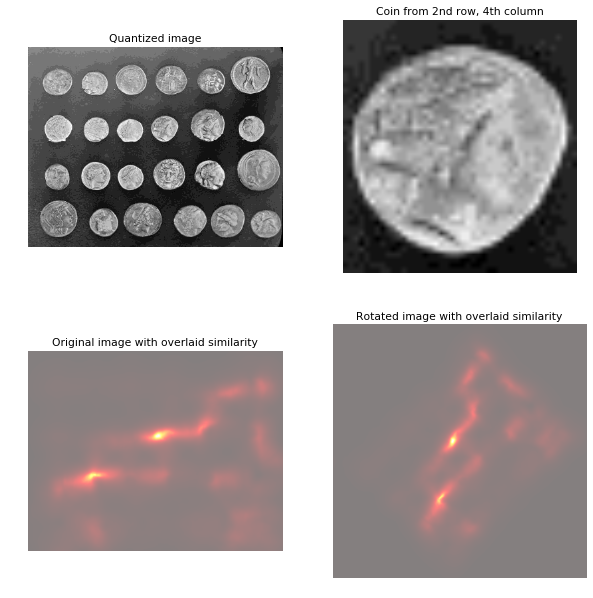

In [55]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3

from skimage import data, transform
from skimage.util import img_as_ubyte
from skimage.morphology import disk, rectangle
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def windowed_histogram_similarity(image, selem, reference_hist, n_bins):
    # Compute normalized windowed histogram feature vector for each pixel
    px_histograms = rank.windowed_histogram(image, selem, n_bins=n_bins)

    # Reshape coin histogram to (1,1,N) for broadcast when we want to use it in
    # arithmetic operations with the windowed histograms from the image
    reference_hist = reference_hist.reshape((1, 1) + reference_hist.shape)

    # Compute Chi squared distance metric: sum((X-Y)^2 / (X+Y));
    # a measure of distance between histograms
    X = px_histograms
    Y = reference_hist

    num = (X - Y) ** 2
    denom = X + Y
    denom[denom == 0] = np.infty
    frac = num / denom

    chi_sqr = 0.5 * np.sum(frac, axis=2)

    # Generate a similarity measure. It needs to be low when distance is high
    # and high when distance is low; taking the reciprocal will do this.
    # Chi squared will always be >= 0, add small value to prevent divide by 0.
    similarity = 1 / (chi_sqr + 1.0e-4)

    return similarity
face_png = data.imread('./training.png')

# Load the `skimage.data.coins` image
img = img_as_ubyte(data.coins())
img_face = img_as_ubyte(face_png) // 16

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin_coords = [184, 100, 228, 148]   # 44 x 44 region
coin = quantized_img[coin_coords[1]:coin_coords[3],
                     coin_coords[0]:coin_coords[2]]

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0, 16))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)
face_hist, _ = np.histogram(img_face.flatten(), bins=16, range=(0, 16))
face_hist = face_hist.astype(float) / np.sum(face_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = disk(30)


# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img // 16
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.show()


# Exploring Histograms

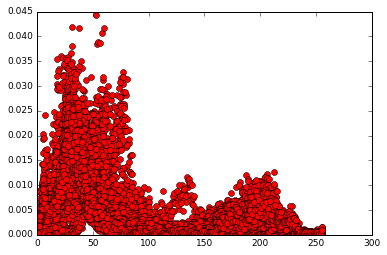

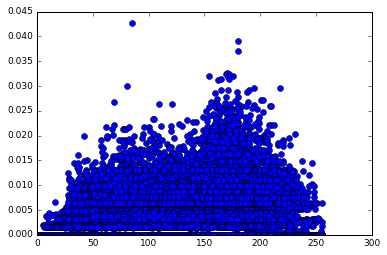

In [99]:
conn = sqlite3.connect('sessions.db')
c = conn.cursor()
rows = [r for r in c.execute("SELECT * FROM readings WHERE subject_type='none'")]
image_paths = ['image_data/{}'.format(r[5]) for r in rows]
X = [data.imread(p) for p in image_paths]

plt.hold(True)
for background in X:
    hist_back = np.histogram(background, bins=255, range=(0, 255))
    plt.plot(hist_back[1][1:], hist_back[0]/(background.shape[0]*background.shape[1]), 'ro')

plt.figure()
saved_face_regions = np.load('face_regions.npy')
for row in saved_face_regions:
    y = row[1][0]
    x = row[1][1]
    height = row[1][2]
    width = row[1][3]
    face_img = data.imread(row[0])[x:x+width,y:y+height]
    hist_face = np.histogram(face_img, bins=255, range=(0, 255))
    plt.plot(hist_face[1][1:], hist_face[0]/(face_img.shape[0]*face_img.shape[1]), 'bo')


plt.hold(False)



# Quantized 16 bin Image with 0-255 Range

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


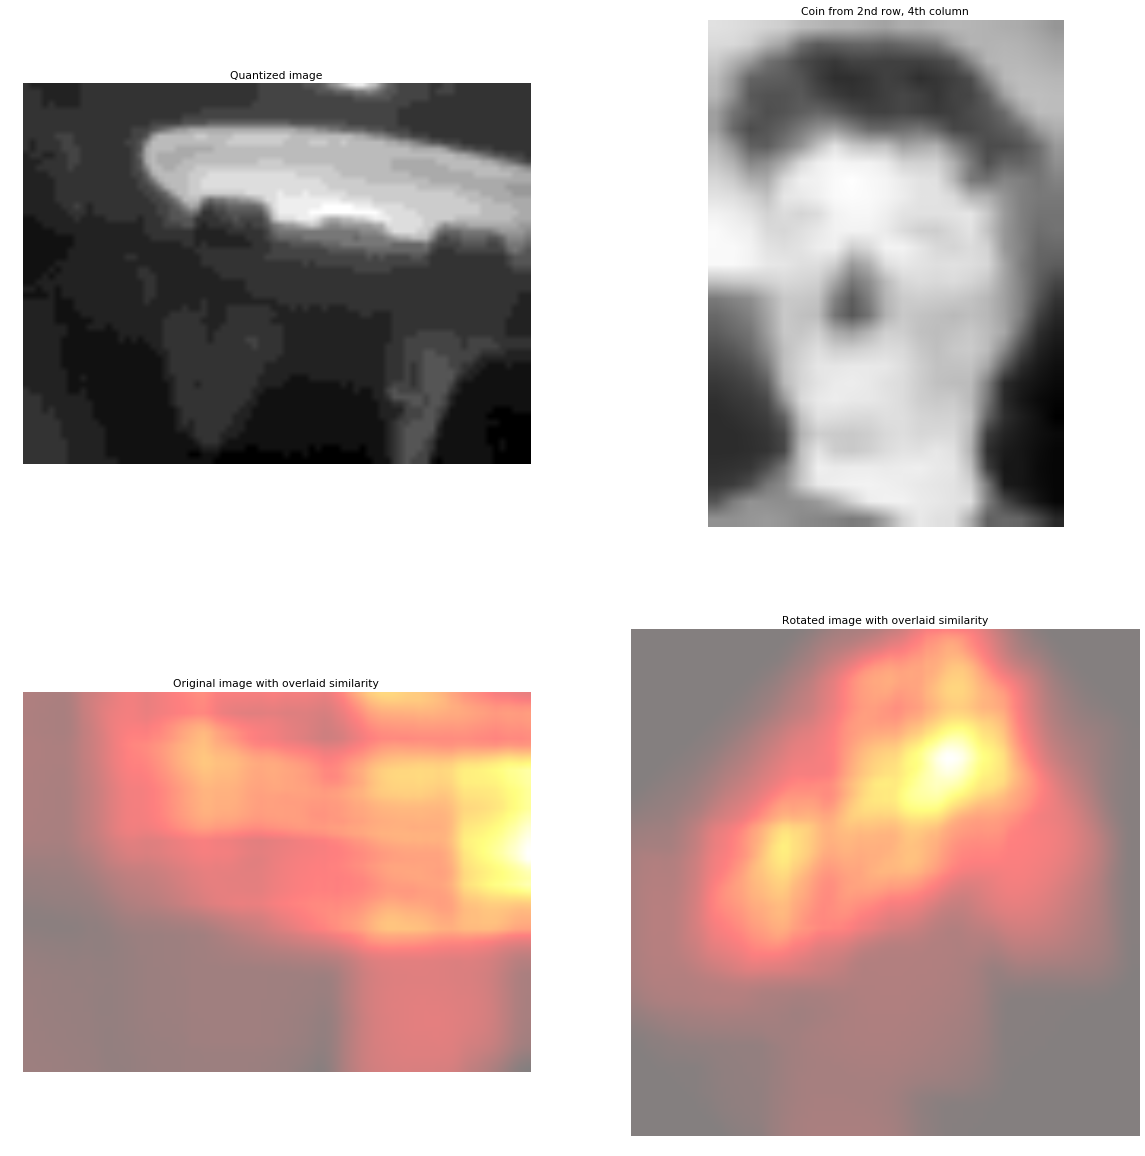

In [91]:
matplotlib.rcParams['font.size'] = 9

face_png = data.imread('training.png', as_grey=True)

# Load the `skimage.data.coins` image
img = X[0]
quantized_img = img//16
img_face = img_as_ubyte(face_png)

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
# quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin = img_face

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0,255))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = rectangle(img_face.shape[0],img_face.shape[1])


# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img // 16
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.show()


# Non-quantized bin Image with 0-255 Range

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


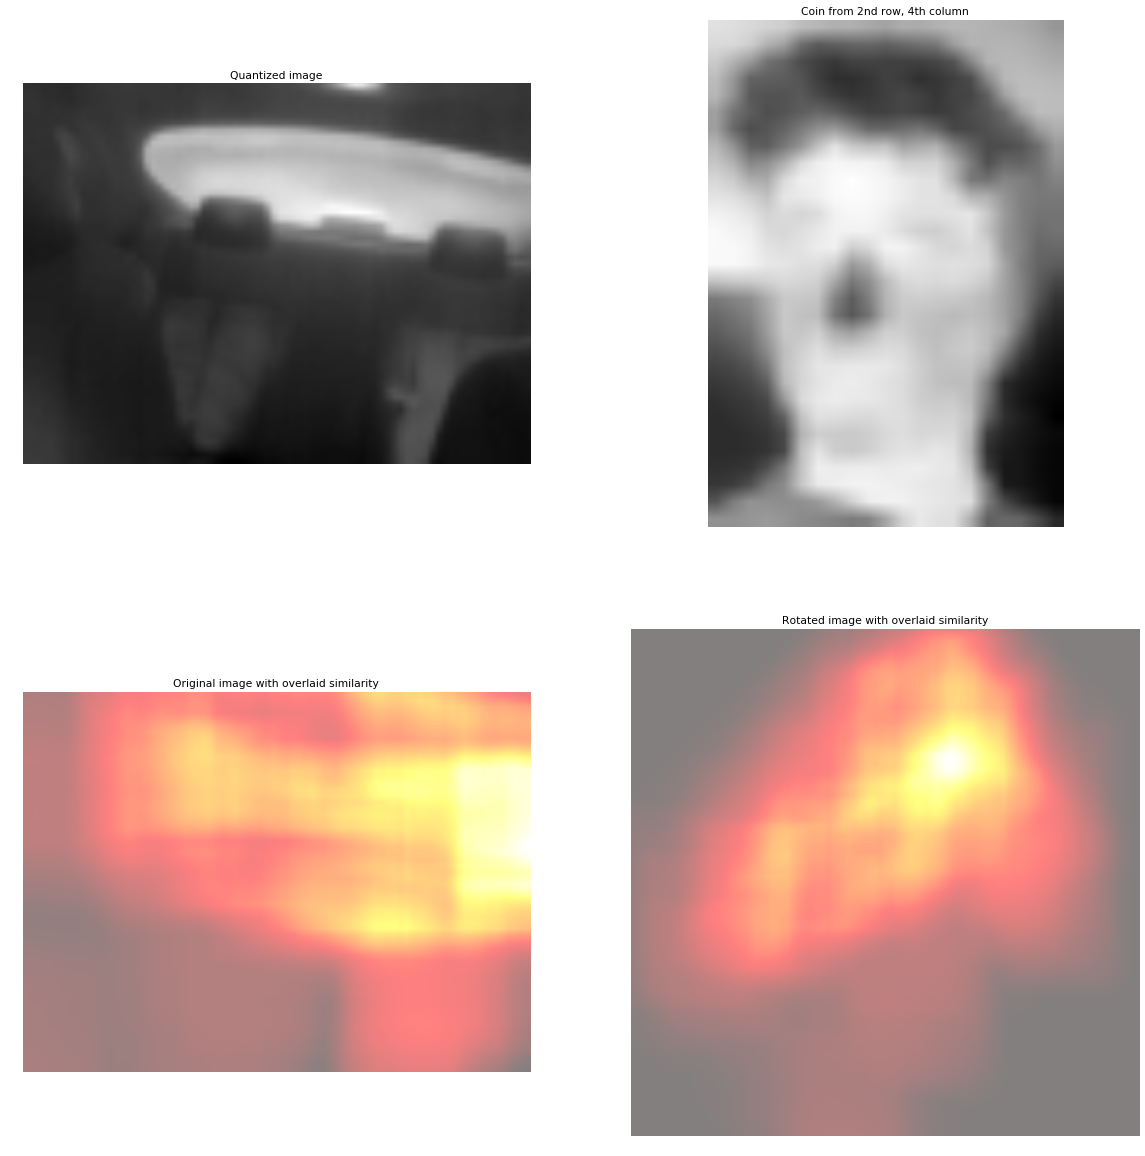

In [92]:
matplotlib.rcParams['font.size'] = 9

face_png = data.imread('training.png', as_grey=True)

# Load the `skimage.data.coins` image
img = X[0]
quantized_img = img
img_face = img_as_ubyte(face_png)

# Quantize to 16 levels of greyscale; this way the output image will have a
# 16-dimensional feature vector per pixel
# quantized_img = img // 16

# Select the coin from the 4th column, second row.
# Co-ordinate ordering: [x1,y1,x2,y2]
coin = img_face

# Compute coin histogram and normalize
coin_hist, _ = np.histogram(coin.flatten(), bins=255, range=(0,255))
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)

# Compute a disk shaped mask that will define the shape of our sliding window
# Example coin is ~44px across, so make a disk 61px wide (2 * rad + 1) to be
# big enough for other coins too.
selem = rectangle(img_face.shape[0],img_face.shape[1])


# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])

# Now try a rotated image
rotated_img = img_as_ubyte(transform.rotate(img, 45.0, resize=True))
# Quantize to 16 levels as before
quantized_rotated_image = rotated_img
# Similarity on rotated image
rotated_similarity = windowed_histogram_similarity(quantized_rotated_image,
                                                   selem, coin_hist,
                                                   coin_hist.shape[0])


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0, 0].imshow(quantized_img, cmap='gray')
axes[0, 0].set_title('Quantized image')
axes[0, 0].axis('off')

axes[0, 1].imshow(coin, cmap='gray')
axes[0, 1].set_title('Coin from 2nd row, 4th column')
axes[0, 1].axis('off')

axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].imshow(similarity, cmap='hot', alpha=0.5)
axes[1, 0].set_title('Original image with overlaid similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(rotated_img, cmap='gray')
axes[1, 1].imshow(rotated_similarity, cmap='hot', alpha=0.5)
axes[1, 1].set_title('Rotated image with overlaid similarity')
axes[1, 1].axis('off')

plt.show()

In [62]:
similarity

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [82]:
coin_hist, _ = np.histogram(coin.flatten(), bins=16, range=(0, 255))
#coin_hist = coin_hist.astype(float) / np.sum(coin_hist)
coin_hist

array([  0,   6,  25,  48,  61,  61,  55,  50,  94, 127, 102,   1,   0,
         0,   0,   0])

In [67]:
coin.flatten()

array([159, 157, 154, 151, 148, 138, 134, 130, 130, 126, 123, 129, 127,
       131, 134, 133, 131, 129, 127, 122, 115, 155, 154, 148, 131, 121,
        92,  80,  83,  86,  87,  84,  88,  93,  97, 119, 132, 132, 133,
       131, 127, 123, 146, 132, 118,  94,  86,  71,  64,  60,  66,  66,
        65,  65,  65,  68,  76, 106, 132, 135, 134, 131, 128, 137, 116,
        85,  83,  81,  76,  63,  54,  54,  58,  65,  62,  54,  58,  64,
        71, 108, 135, 138, 136, 134, 134, 112,  79,  75,  75,  79,  70,
        62,  57,  59,  64,  68,  65,  58,  66,  67,  83, 121, 138, 139,
       137, 120,  95,  82,  73,  76,  82,  87,  81,  71,  65,  65,  68,
        65,  61,  64,  71,  77,  90, 122, 138, 137, 120,  88,  72,  77,
        85,  99, 112, 118, 104,  88,  87,  91,  96,  86,  68,  69,  74,
        81,  90, 118, 129, 134, 113,  84,  81,  97, 114, 140, 161, 145,
       139, 141, 122, 127, 131, 105,  86,  71,  72,  77,  91, 117, 143,
       131, 106, 111, 129, 155, 167, 172, 170, 170, 165, 151, 15

In [ ]:
hist[1][1:].shape